# Basic Setup

### Load Libraries and define functions

In [0]:
# Load Libraries
import numpy as np
import pandas as pd
import glob
import re
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score 

# Load Pytorch Libraries
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler, RandomSampler

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer

from torch.utils.data import TensorDataset
##@ Set Seeds
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True

In [30]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tesla P100-PCIE-16GB
Sun May 24 23:07:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |   5299MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       

In [0]:
# Define Functions

#Define function to split words
def splitwords(mydataframe, maxSeqLength, ReportOrderChanged = False):
    ''' 
    Takes in my dataframe with columns "original" and "summary"
    Returns the sentences and summaries in list of words, plus length in dataframe format
    Also returns which sentences have word order chnaged in summary
    '''
    x = list(mydataframe['original'])
    y = list(mydataframe['summary'])
    xsplit = []
    ysplit = []
    xlen = []
    ylen = []
    labelslist = []
    orderchanged = []

    for i in range(len(x)):
        xwords = re.findall(r"[\w]+|[^\s\w]", x[i].lower()+'.')
        ywords = re.findall(r"[\w]+|[^\s\w]", y[i].lower())
        xsplit.append(xwords)
        ysplit.append(ywords)
        xlen.append(len(xwords))
        ylen.append(len(ywords))

    for j in range(len(xsplit)):
        x1 = xsplit[j]
        y1 = ysplit[j]
        labels = [0]*maxSeqLength
        pointer = 0
        for wordindex in range(len(x1)):
            if x1[wordindex] == y1[pointer]:
                labels[wordindex] = 1
                pointer += 1
            if pointer > len(y1)-1:
                break
            if wordindex > len(labels)-1:
                break            
        labelslist.append(labels)
        if len(ysplit[j]) != sum(labels):
            if ReportOrderChanged == True:
                print("Error occured in labelling at item", j,)
                print(xsplit[j])
                print(ysplit[j])
                print(labels)
            orderchanged.append(1)
        else:
            orderchanged.append(0)
    mydataframe['xsplit'] = xsplit
    mydataframe['ysplit'] = ysplit
    mydataframe['xlen'] = xlen
    mydataframe['ylen'] = ylen
    mydataframe['labelslist'] = labelslist
    mydataframe['orderchanged'] = orderchanged
    return mydataframe

##@ Define function to check per-sentence accuracy (i.e., how many compressions could be fully reproduced)
'''
Inputs: Vector of predicted values shape (m, MaxSentenceLength)
Outputs: Sentence Accuracy, list of matches or non-matches (1s or 0s)
'''
def persentenceACC(predicted,labels):
    same = []
    for i in range(len(predicted)):
        if np.array_equal(predicted[i], labels[i]):
            same.append(True)
        else:
            same.append(False)
    sentenceaccuracy = np.sum(same)/len(predicted)
    return sentenceaccuracy, same

### Load glove Model

In [32]:
# Load glove model with pretrained embeddings
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    counter = 0
    for line in f:
        # print(line)
        # break
        splitLines = line.split(" ")
        # print(splitLines)
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
        counter += 1
        if counter % 100000 == 0:
            print(counter)
    print(len(gloveModel)," words loaded!")
    return gloveModel
gloveModel = loadGloveModel("/content/drive/My Drive/DeepLearningProject/glove.840B.300d.txt") ##@ This makes a dictionary of embeddings


Loading Glove Model
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2196016  words loaded!


In [33]:
## Add a vector for "unknown" words (https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt)
unknownEmbedding = "0.22418134 -0.28881392 0.13854356 0.00365387 -0.12870757 0.10243822 0.061626635 0.07318011 -0.061350107 -1.3477012 0.42037755 -0.063593924 -0.09683349 0.18086134 0.23704372 0.014126852 0.170096 -1.1491593 0.31497982 0.06622181 0.024687296 0.076693475 0.13851812 0.021302193 -0.06640582 -0.010336159 0.13523154 -0.042144544 -0.11938788 0.006948221 0.13333307 -0.18276379 0.052385733 0.008943111 -0.23957317 0.08500333 -0.006894406 0.0015864656 0.063391194 0.19177166 -0.13113557 -0.11295479 -0.14276934 0.03413971 -0.034278486 -0.051366422 0.18891625 -0.16673574 -0.057783455 0.036823478 0.08078679 0.022949161 0.033298038 0.011784158 0.05643189 -0.042776518 0.011959623 0.011552498 -0.0007971594 0.11300405 -0.031369694 -0.0061559738 -0.009043574 -0.415336 -0.18870236 0.13708843 0.005911723 -0.113035575 -0.030096142 -0.23908928 -0.05354085 -0.044904727 -0.20228513 0.0065645403 -0.09578946 -0.07391877 -0.06487607 0.111740574 -0.048649278 -0.16565254 -0.052037314 -0.078968436 0.13684988 0.0757494 -0.006275573 0.28693774 0.52017444 -0.0877165 -0.33010918 -0.1359622 0.114895485 -0.09744406 0.06269521 0.12118575 -0.08026362 0.35256687 -0.060017522 -0.04889904 -0.06828978 0.088740796 0.003964443 -0.0766291 0.1263925 0.07809314 -0.023164088 -0.5680669 -0.037892066 -0.1350967 -0.11351585 -0.111434504 -0.0905027 0.25174105 -0.14841858 0.034635577 -0.07334565 0.06320108 -0.038343467 -0.05413284 0.042197507 -0.090380974 -0.070528865 -0.009174437 0.009069661 0.1405178 0.02958134 -0.036431845 -0.08625681 0.042951006 0.08230793 0.0903314 -0.12279937 -0.013899368 0.048119213 0.08678239 -0.14450377 -0.04424887 0.018319942 0.015026873 -0.100526 0.06021201 0.74059093 -0.0016333034 -0.24960588 -0.023739101 0.016396184 0.11928964 0.13950661 -0.031624354 -0.01645025 0.14079992 -0.0002824564 -0.08052984 -0.0021310581 -0.025350995 0.086938225 0.14308536 0.17146006 -0.13943303 0.048792403 0.09274929 -0.053167373 0.031103406 0.012354865 0.21057427 0.32618305 0.18015954 -0.15881181 0.15322933 -0.22558987 -0.04200665 0.0084689725 0.038156632 0.15188617 0.13274793 0.113756925 -0.095273495 -0.049490947 -0.10265804 -0.27064866 -0.034567792 -0.018810693 -0.0010360252 0.10340131 0.13883452 0.21131058 -0.01981019 0.1833468 -0.10751636 -0.03128868 0.02518242 0.23232952 0.042052146 0.11731903 -0.15506615 0.0063580726 -0.15429358 0.1511722 0.12745973 0.2576985 -0.25486213 -0.0709463 0.17983761 0.054027 -0.09884228 -0.24595179 -0.093028545 -0.028203879 0.094398156 0.09233813 0.029291354 0.13110267 0.15682974 -0.016919162 0.23927948 -0.1343307 -0.22422817 0.14634751 -0.064993896 0.4703685 -0.027190214 0.06224946 -0.091360025 0.21490277 -0.19562101 -0.10032754 -0.09056772 -0.06203493 -0.18876675 -0.10963594 -0.27734384 0.12616494 -0.02217992 -0.16058226 -0.080475815 0.026953284 0.110732645 0.014894041 0.09416802 0.14299914 -0.1594008 -0.066080004 -0.007995227 -0.11668856 -0.13081996 -0.09237365 0.14741232 0.09180138 0.081735 0.3211204 -0.0036552632 -0.047030564 -0.02311798 0.048961394 0.08669574 -0.06766279 -0.50028914 -0.048515294 0.14144728 -0.032994404 -0.11954345 -0.14929578 -0.2388355 -0.019883996 -0.15917352 -0.052084364 0.2801028 -0.0029121689 -0.054581646 -0.47385484 0.17112483 -0.12066923 -0.042173345 0.1395337 0.26115036 0.012869649 0.009291686 -0.0026459037 -0.075331464 0.017840583 -0.26869613 -0.21820338 -0.17084768 -0.1022808 -0.055290595 0.13513643 0.12362477 -0.10980586 0.13980341 -0.20233242 0.08813751 0.3849736 -0.10653763 -0.06199595 0.028849555 0.03230154 0.023856193 0.069950655 0.19310954 -0.077677034 -0.144811"
unknownEmbedding = unknownEmbedding.split(" ")
len(unknownEmbedding)

300

### Import Data

In [34]:
# Get list of files
inputs = glob.glob("/content/drive/My Drive/DeepLearningProject/csv/*.csv")
inputs.sort()
print(inputs)
filename = inputs[0]
filename2 = inputs[1]
print(filename)
print(filename2)

['/content/drive/My Drive/DeepLearningProject/csv/comp-data.eval.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train01.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train02.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train03.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train04.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train05.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train06.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train07.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train08.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train09.csv', '/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train10.csv']
/content/drive/My Drive/DeepLearningProject/csv/comp-data.eval.csv
/content/drive/My Drive/DeepLearningProject/csv/sent-comp.train01.csv


In [35]:
# Read In Test Data
filename = inputs[0]
rawdatatest = pd.read_csv(filename)
print("Raw test data examples:", len(rawdatatest))

# Read In Train Data
filename2 = inputs[1]
rawdatatrain= pd.read_csv(filename2)
print("Raw train data examples:" ,len(rawdatatrain))
for i in range(2,len(inputs)):
    filename2 = inputs[i]
    print("Loading",filename2)
    rawdatanext= pd.read_csv(filename2)
    rawdatatrain = pd.concat([rawdatatrain,rawdatanext])
    print("Raw train data examples:",len(rawdatatrain))

Raw test data examples: 10000
Raw train data examples: 20000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train02.csv
Raw train data examples: 40000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train03.csv
Raw train data examples: 60000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train04.csv
Raw train data examples: 80000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train05.csv
Raw train data examples: 100000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train06.csv
Raw train data examples: 120000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train07.csv
Raw train data examples: 140000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train08.csv
Raw train data examples: 160000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-comp.train09.csv
Raw train data examples: 180000
Loading /content/drive/My Drive/DeepLearningProject/csv/sent-c

### Data Preprocessing

#### Create dataframes of Train and Test sets, filter , then construct labels

In [36]:
## Set max sequence length
maxSequenceLength = 300

#Test data
testdf = splitwords(rawdatatest, maxSeqLength = 300)
sum(testdf['orderchanged'])
print("Original Data Length", len(testdf))
temp = sum(testdf['orderchanged'])
print("Removing", temp, "cases where word order is changed")
testdf = testdf.loc[testdf['orderchanged']==0,]
temp = sum(testdf['xlen']>maxSequenceLength)
print("Removing",temp, "cases where sequence length > maxSequenceLength")
testdf = testdf.loc[testdf['xlen']<=maxSequenceLength,]
print("Test data length:",len(testdf))

# Train data
traindf = splitwords(rawdatatrain,  maxSeqLength = 300)
sum(traindf['orderchanged'])
print("Original Data Length", len(traindf))
temp = sum(traindf['orderchanged'])
print("Removing", temp, "cases where word order is changed")
traindf = traindf.loc[traindf['orderchanged']==0,]
temp = sum(traindf['xlen']>maxSequenceLength)
print("Removing",temp, "cases where sequence length > maxSequenceLength")
traindf = traindf.loc[traindf['xlen']<=maxSequenceLength,]
print("Train data length:",len(traindf))
traindf.head(1)

Original Data Length 10000
Removing 54 cases where word order is changed
Removing 0 cases where sequence length > maxSequenceLength
Test data length: 9946
Original Data Length 200000
Removing 1219 cases where word order is changed
Removing 39 cases where sequence length > maxSequenceLength
Train data length: 198742


,original,summary,xsplit,ysplit,xlen,ylen,labelslist,orderchanged
0,Serge Ibaka -- the Oklahoma City Thunder forwa...,Serge Ibaka has been granted Spanish citizensh...,"[serge, ibaka, -, -, the, oklahoma, city, thun...","[serge, ibaka, has, been, granted, spanish, ci...",50,13,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


#### Create a Tokenizer based on glove embeddings

In [37]:
##@ create tokenenizer
tokenizer = Tokenizer(num_words = len(gloveModel.keys()),##@ Initialize Tokenizer (2196016 vocab size from glove model)
                      oov_token='unknn') 
print("initialized tokenizer")
tokenizer.fit_on_texts(gloveModel.keys()) ##@ Increase our vocabulary (Updates internal vocabulary based on a list of texts)
print("fitted tokenizer")
word_index = tokenizer.word_index ##@ Dict of word to index (Transforms each text in texts to a sequence of integers)
print("Generated word index")

##@ Creates an array of (Vocabsize,embeddinglength), to be indexed by the word_indexer
embedding_matrix = np.zeros((len(word_index) + 1, 300)) 
for word, i in word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix[word_index.get('unknn')] = np.array(unknownEmbedding) ##@ Set vector for unknown word
print("Generated embedding_matrix")
max_features = 300
embed_size = 300

initialized tokenizer
fitted tokenizer
Generated word index
Generated embedding_matrix


#### Tokenize train data and pad sequences

In [0]:
##@ Define my own text to sequences
x_train = np.array(traindf['xsplit'])
y_train = np.array(list(traindf['labelslist']))

##@ Tokenize sentences
x_train = tokenizer.texts_to_sequences(x_train)

##@ Check length
lengthcheck = []
for i in x_train:
    lengthcheck.append(len(i))
traindf['checktokenizerlength'] = lengthcheck
if sum(traindf['xlen']-traindf['checktokenizerlength']) != 0:
    print("Problem with tokenizer due to sentence length!")

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen = max_features)

#### Split data into training and validation (dev) sets, and construct dataloader for batch processing

In [0]:
## create training and validation split 
split = int(0.95 * len(x_train))
index_list = list(range(len(x_train)))
train_idx, valid_idx = index_list[:split], index_list[split:]

## create iterator objects for train and valid datasets
x_tr = torch.tensor(x_train[train_idx], dtype=torch.long)
y_tr = torch.tensor(y_train[train_idx], dtype=torch.float32)
train = TensorDataset(x_tr, y_tr)
prediction_sampler = RandomSampler(train) # Random sampler
trainloader = DataLoader(train,sampler = prediction_sampler, batch_size=128)

x_val = torch.tensor(x_train[valid_idx], dtype=torch.long)
y_val = torch.tensor(y_train[valid_idx], dtype=torch.float32)
valid = TensorDataset(x_val, y_val)
prediction_sampler = RandomSampler(valid) # Random sampler

validloader = DataLoader(valid, sampler = prediction_sampler, batch_size=128)

# Construct Model

In [0]:
#https://blog.exxactcorp.com/getting-started-with-natural-language-processing-using-pytorch/

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        ## Embedding Layer, Add parameter 
        self.embedding = nn.Embedding(max_features, embed_size)   ##@ Pytorch embedding layer, read more if i can
        et = torch.tensor(embedding_matrix, dtype=torch.float32)  ##@ makes the vector lookup array into a tensor
        self.embedding.weight = nn.Parameter(et)                  ##@ Weights for embedding layer is the embeddings? 
        self.embedding.weight.requires_grad = False               ##@ Our glove embeddings will not be trainable
        self.embedding_dropout = nn.Dropout2d(0.1)                ##@ guess he adds dropout for embeddings too
        self.lstm = nn.LSTM(300, 40) 
        self.lstm2 = nn.LSTM(300, 300)      
        self.lstm3 = nn.LSTM(300, 300, num_layers = 2, bidirectional = True, dropout = 0.1)        
        self.linear = nn.Linear(40, 16)
        self.linear1 = nn.Linear(600, 300)
        self.linear2 = nn.Linear(300, 300)
        self.linear3 = nn.Linear(1000, 500)
        self.out = nn.Linear(16, 300)
        self.out2 = nn.Linear(300, 300)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # def forward(self, x):
    #     h_embedding = self.embedding(x)        
    #     h_lstm, _ = self.lstm(h_embedding)
    #     max_pool, _ = torch.max(h_lstm, 1)        
    #     linear = self.relu(self.linear(max_pool))
    #     out = self.sigmoid(self.out(linear))
    #     return out

#My baseline
    # def forward(self, x):
    #     h_embedding = self.embedding(x) 
    #     h_lstm, _ = self.lstm3(h_embedding)
    #     max_pool, _ = torch.max(h_lstm, 1)
    #     h_linear1 = self.relu(self.linear1(max_pool))
    #     h_linear2 = self.relu(self.linear2(h_linear1))
    #     h_linear2 = self.relu(self.linear2(h_linear2))
    #     h_linear2 = self.relu(self.linear2(h_linear2))
    #     h_linear2 = self.relu(self.linear2(h_linear2))
    #     h_linear2 = self.relu(self.linear2(h_linear2))
    #     h_linear2 = self.relu(self.linear2(h_linear2))
    #     h_linear2 = self.relu(self.linear2(h_linear2))
    #     h_linear3 = self.relu(self.linear3(h_linear2)) 
    #     out = self.sigmoid(self.out2(h_linear3))
    #     return out

#My baseline 2
    def forward(self, x):
        h_embedding = self.embedding(x) 
        h_lstm, _ = self.lstm2(h_embedding)
        max_pool, _ = torch.max(h_lstm, 1)
        h_linear1 = self.relu(self.linear2(max_pool))
        # h_linear2 = self.relu(self.linear2(h_linear1))
        # h_linear3 = self.relu(self.linear3(h_linear2)) 
        out = self.sigmoid(self.out2(h_linear1))
        return out

model = Model()  

# ##@ Test embeddings
# embed = nn.Embedding(max_features, embed_size) 
# input1 = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
# print(input1.shape)
# output1 = embed(input1)
# print(output1.shape)

In [55]:
##@ Put model on GPU
model.cuda()

Model(
  (embedding): Embedding(300, 300)
  (embedding_dropout): Dropout2d(p=0.1, inplace=False)
  (lstm): LSTM(300, 40)
  (lstm2): LSTM(300, 300)
  (lstm3): LSTM(300, 300, num_layers=2, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=40, out_features=16, bias=True)
  (linear1): Linear(in_features=600, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=16, out_features=300, bias=True)
  (out2): Linear(in_features=300, out_features=300, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [0]:
##@ Define Loss Function and optimizer

loss_function = nn.BCEWithLogitsLoss(reduction='mean') #https://discuss.pytorch.org/t/is-there-an-example-for-multi-class-multilabel-classification-in-pytorch/53579/11
optimizer = optim.Adam(model.parameters(),lr=0.001) #https://pytorch.org/docs/stable/optim.html

### Other things may want to try: loss
# https://discuss.pytorch.org/t/multi-label-classification-in-pytorch/905/11

### Begin Training


In [57]:
num_epochs = 20

##@ Begin Training

# Store our loss and accuracy for plotting
train_loss_set = []
valid_loss_set = []

for epoch in range(1, num_epochs+1): ## run the model for 10 epochs
    train_loss, valid_loss = [], []
    ## training part 
    model.train()
    for data, target in trainloader:
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        ## 1. forward propagation (Forward pass)
        output = model(data)
        
        ## 2. loss calculation
        loss = loss_function(output, target)
        
        ## 3. backward propagation (Backward pass)
        loss.backward()
        
        ## 4. weight optimization (# Update parameters and take a step using the computed gradient)
        optimizer.step()
        
        train_loss.append(loss.item()) ##@ Each step we append to trainloss
    train_loss_set.append(np.mean(train_loss)) ##@ Store each epoch's loss for plotting

    ## evaluation part for each epoch
    model.eval() ##@ Set model to evaluation mode

    # Tracking variables 
    predictions , true_labels = [], []

    for data, target in validloader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # Move output and labels to CPU
        output = output.detach().cpu()
        target = target.to('cpu')

        loss = loss_function(output, target)
        valid_loss.append(loss.item())

         # Store predictions and true labels
        predictions.append(output)
        true_labels.append(target)

    valid_loss_set.append(np.mean(valid_loss))

    # Calculate Metrics (per epoch)
    # SentenceAccuracy
    temp_flat_predictions = np.array([np.array(item) for sublist in predictions for item in sublist])
    temp_flat_predictions_binary = np.where(temp_flat_predictions > 0.5, 1, 0)
    temp_flat_labels = np.array([np.array(item) for sublist in true_labels for item in sublist])

    sentenceaccuracy, _ = persentenceACC(temp_flat_predictions_binary,temp_flat_labels)

    # Word-level F1 score
    longlistpredictions = temp_flat_predictions_binary.flatten()
    longlistlabels = temp_flat_labels.flatten()
    f1 = f1_score(longlistlabels,longlistpredictions)

    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss), "Valid SA: ",sentenceaccuracy, "Valid F1_Score: ", f1)

Epoch: 1 Training Loss:  0.6940699426866159 Valid Loss:  0.692131614837891 Valid SA:  0.0 Valid F1_Score:  0.4159352053526013
Epoch: 2 Training Loss:  0.6918378797003893 Valid Loss:  0.6913560155110482 Valid SA:  0.0 Valid F1_Score:  0.45025748530283005
Epoch: 3 Training Loss:  0.6910934980484206 Valid Loss:  0.6908937501601684 Valid SA:  0.0 Valid F1_Score:  0.44090520174357106
Epoch: 4 Training Loss:  0.690784384887716 Valid Loss:  0.6906804427122458 Valid SA:  0.0 Valid F1_Score:  0.45305320212245004
Epoch: 5 Training Loss:  0.6906217272850234 Valid Loss:  0.6906318825024825 Valid SA:  0.0 Valid F1_Score:  0.43497517296397675
Epoch: 6 Training Loss:  0.6904897026334028 Valid Loss:  0.6904892126719157 Valid SA:  0.0 Valid F1_Score:  0.4649796746610775
Epoch: 7 Training Loss:  0.6904045350264082 Valid Loss:  0.6904286016256381 Valid SA:  0.0 Valid F1_Score:  0.505043323705843
Epoch: 8 Training Loss:  0.6903140540449277 Valid Loss:  0.6904001021996523 Valid SA:  0.0001006238679814852 V

In [0]:
# hello

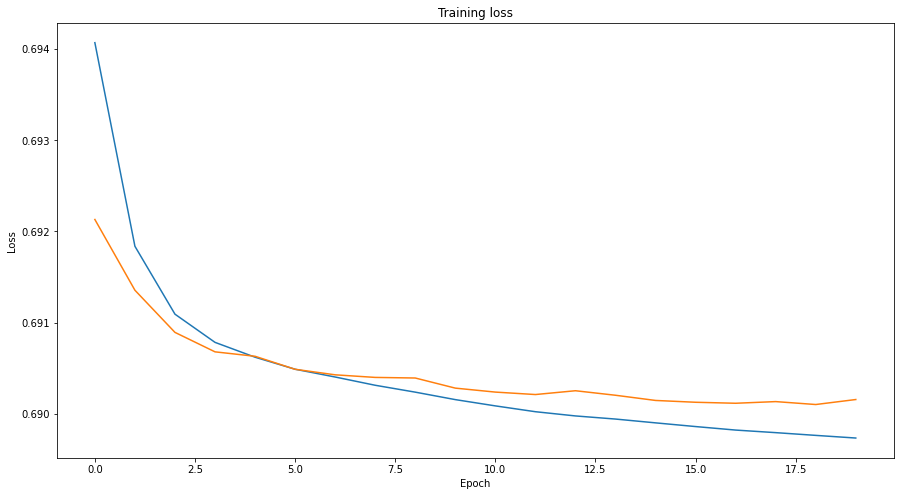

In [59]:
## Plot Training and Validation Loss
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.plot(valid_loss_set)
plt.show()

### Save Model

In [0]:
# Save the model
PATH = '/content/drive/My Drive/DeepLearningProject/models/basicmodel.pth'
torch.save(model.state_dict(), PATH)

#Predict and Evaluate on Test Set

### Load model weights

In [61]:
### Load Model
model2 = model
PATH = '/content/drive/My Drive/DeepLearningProject/models/basicmodel.pth'
model2.load_state_dict(torch.load(PATH))
model2.cuda

<bound method Module.cuda of Model(
  (embedding): Embedding(300, 300)
  (embedding_dropout): Dropout2d(p=0.1, inplace=False)
  (lstm): LSTM(300, 40)
  (lstm2): LSTM(300, 300)
  (lstm3): LSTM(300, 300, num_layers=2, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=40, out_features=16, bias=True)
  (linear1): Linear(in_features=600, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=16, out_features=300, bias=True)
  (out2): Linear(in_features=300, out_features=300, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)>

In [0]:
##@ Define my own text to sequences
x_test = np.array(testdf['xsplit'])
y_test = np.array(list(testdf['labelslist']))

##@ Tokenize sentences
x_test = tokenizer.texts_to_sequences(x_test)

##@ Check length
lengthcheck = []
for i in x_test:
    lengthcheck.append(len(i))
testdf['checktokenizerlength'] = lengthcheck
if sum(testdf['xlen']-testdf['checktokenizerlength']) != 0:
    print("Problem with tokenizer due to sentence length!")

# Pad sequences
x_test = sequence.pad_sequences(x_test, maxlen = max_features)

## create iterator objects for test dataset
x_ts = torch.tensor(x_test, dtype=torch.long)
y_ts = torch.tensor(y_test, dtype=torch.float32)
test = TensorDataset(x_ts, y_ts)
prediction_sampler = SequentialSampler(test)
testloader = DataLoader(test,sampler = prediction_sampler, batch_size=128)

### Predict on Test Set

In [63]:
# Put model in evaluation mode
model2.eval()

# Tracking variables 
predictions , true_labels = [], []

for data, target in testloader:

    data = data.to(device)
    target = target.to(device)

    output = model2(data)

    # Move output and labels to CPU
    output = output.detach().cpu()
    target = target.to('cpu')

    loss = loss_function(output, target)

    # Store predictions and true labels
    predictions.append(output)
    true_labels.append(target)

#  Calculate Metric
# SentenceAccuracy
temp_flat_predictions = np.array([np.array(item) for sublist in predictions for item in sublist])
temp_flat_predictions_binary = np.where(temp_flat_predictions > 0.5, 1, 0)
temp_flat_labels = np.array([np.array(item) for sublist in true_labels for item in sublist])

sentenceaccuracy, _ = persentenceACC(temp_flat_predictions_binary,temp_flat_labels)

# Word-level F1 score
longlistpredictions = temp_flat_predictions_binary.flatten()
longlistlabels = temp_flat_labels.flatten()
f1 = f1_score(longlistlabels,longlistpredictions)

print ("SA: ",sentenceaccuracy, "F1_Score: ", f1)

SA:  0.0 F1_Score:  0.49671230998398225


In [68]:
test = []
for i in range(100):
    randomnum = np.random.randint(2, size=2983800)
    test.append(f1_score(longlistlabels,randomnum))

print(len(test))
np.mean(test)

100


0.0693914327570599

# Display Results

In [0]:
testsentences = list(testdf['xsplit'])

predsentences = []
for i in range(len(testsentences)):
    predictedsentence = ""
    for j in range(len(testsentences[i])):
        if temp_flat_predictions_binary[i][j] == 1:
            predictedsentence += testsentences[i][j] + " "
    predsentences.append(predictedsentence)
    
testdf['predictedsentence'] = predsentences


In [65]:
checkdf = testdf[['original','summary','predictedsentence']]
checkdf.head()

,original,summary,predictedsentence
0,Five people have been taken to hospital with m...,Five people have been taken to hospital with m...,five people have been taken to hospital with
1,Several school districts in Hampton Roads are ...,Several school districts are holding classes t...,several school districts in
2,Luis Suarez was spotted in London this afterno...,Luis Suarez was spotted in London.,luis suarez was spotted in
3,A woman was injured by a falling tree in the G...,A woman was injured by a falling tree.,a woman was injured by a falling tree in
4,Birmingham poet Benjamin Zephaniah is today le...,Benjamin Zephaniah is today leading an poetry ...,zephaniah is today leading an interactive poet...


In [0]:
checkdf.to_csv('checkdf.csv')

In [0]:
for i in range(999999999999999999999999999):
    x = 10
    